# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
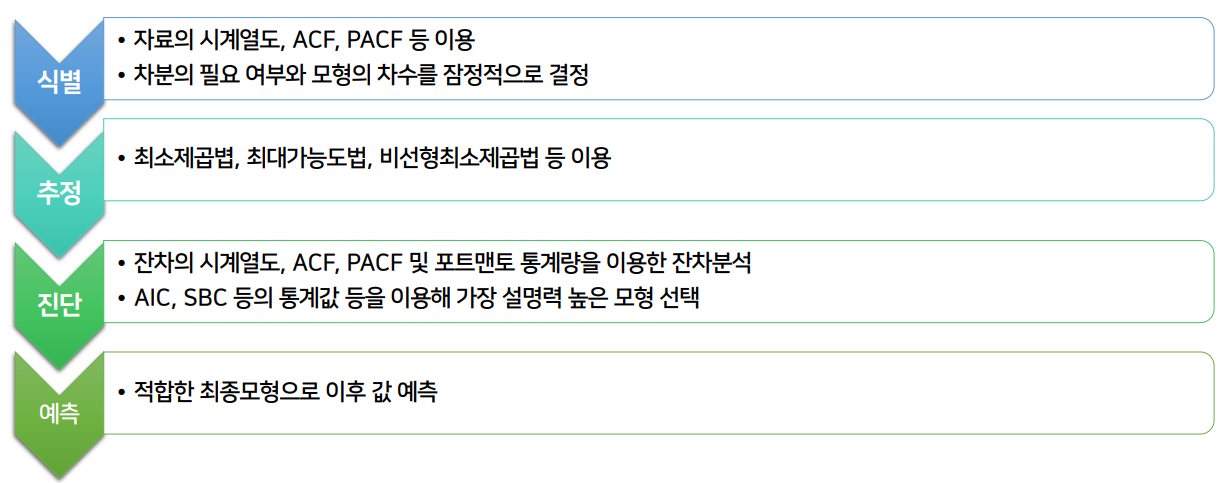

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults

C:\Users\MJHwang\AppData\Local\Temp\ipykernel_25444\2309472473.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 데이터 불러오기

In [28]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


## 1. 식별

<AxesSubplot:xlabel='day'>

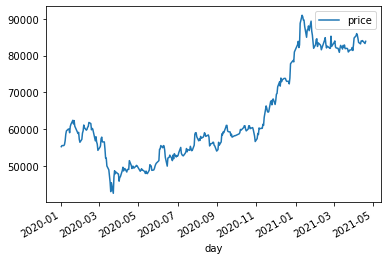

In [29]:
samsung_df.plot()

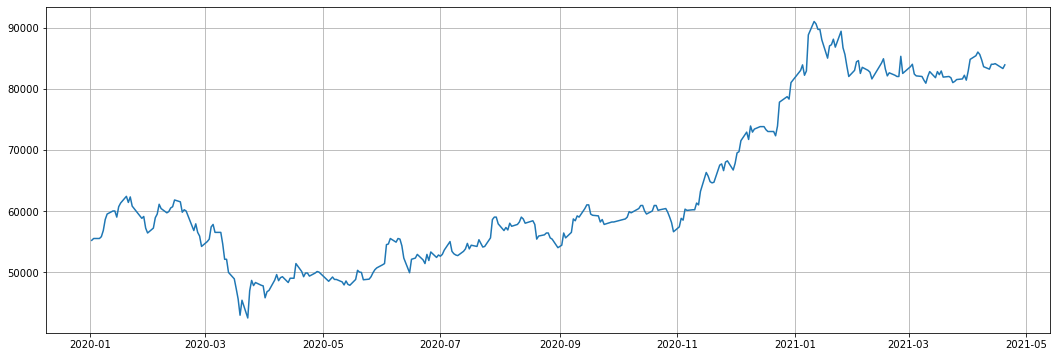

In [30]:
plt.figure(figsize=(18, 6))
plt.plot(samsung_df.index, samsung_df['price'])
plt.xlabel=("day")
plt.ylabel=("price")
plt.grid(True)
plt.show()

- 시계열도 그래프로 살펴본 결과 추세가 존재하는 것으로 판단됨. 정상성 만족 x

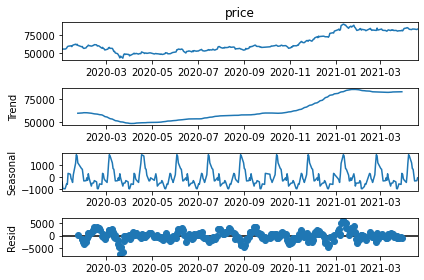

In [31]:
decompose = seasonal_decompose(x = samsung_df['price'], model = "add", period=30) # 계절성 분해
decompose.plot();

- 계절성 분해로 살펴본 결과 계절성이 존재하고 잔차의 정상성을 만족하고 있지 않음이 관찰됨

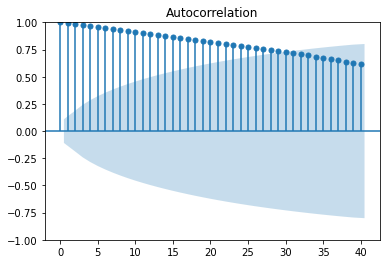

In [32]:
plot_acf(samsung_df, lags=40)
plt.show()

# x축: lag, y축: correlation

- ACF(자기 상관 함수)를 살펴본 결과 파란 범위를 벗어나는 부분이 다수 존재하므로 자기 상관이 존재 -> samsung_df는 정상성 x(안정적X)

C:\Users\MJHwang\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


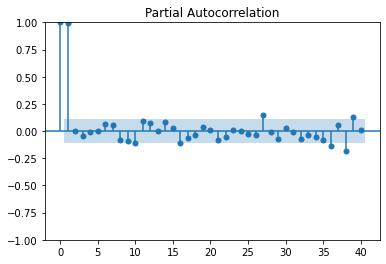

In [33]:
plot_pacf(samsung_df, lags=40)
plt.show()

- PACF(부분 자기 상관 함수)를 살펴본 결과 시차 차이가 1인 것까지 correlation이 높으나 자기 상관 관계가 거의 없음을 알 수 있음

In [34]:
def ADF_test(y):
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(y, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 
                                                 'p-value', 
                                                 'Lags Used', 
                                                 'Number of Observations Used'])
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

ADF_test(samsung_df['price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -0.212189
p-value                          0.937053
Lags Used                        0.000000
Number of Observations Used    321.000000
Critical Value (1%)             -3.450887
Critical Value (5%)             -2.870586
Critical Value (10%)            -2.571590
dtype: float64


- p-value > 0.05 이므로 귀무가설을 기각할 수 없으므로, 시계열은 stationary(안정적)하지 못함

In [35]:
def kpss_test(y):
    print("Results of KPSS Test:")
    kpsstest = kpss(y, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", 
                              "p-value", 
                              "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
kpss_test(samsung_df['price'])

Results of KPSS Test:
Test Statistic            2.145212
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\MJHwang\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


- p-value > 0.05 이므로 귀무가설을 기각할 수 없으므로, 시계열은 stationary하지 못함

In [36]:
model= auto_arima(samsung_df,trace=True, error_action='ignore', start_p=1,start_q=1, 
                  max_p=4,max_q=4,suppress_warnings=True,stepwise=False,seasonal=False)
model.fit(samsung_df)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5477.791, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5479.737, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5481.752, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5483.744, Time=0.03 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=5485.254, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5479.719, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5481.732, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5483.954, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5485.673, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5486.862, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5481.684, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5483.694, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5485.659, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5487.162, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5483.681, Time=0.03 sec
 ARIMA(3,1

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

- AIC를 통해 best model은 ARIMA(0,1,0)으로 판단됨 -> 1차 차분 진행

### - 차분

In [37]:
df_1 = samsung_df.diff().dropna()
df_1
# 1차 차분 후 NaN 제거

,price
day,
2020-01-03,300.0
2020-01-06,0.0
2020-01-07,300.0
2020-01-08,1000.0
2020-01-09,1800.0
...,...
2021-04-14,0.0
2021-04-15,100.0
2021-04-16,-200.0


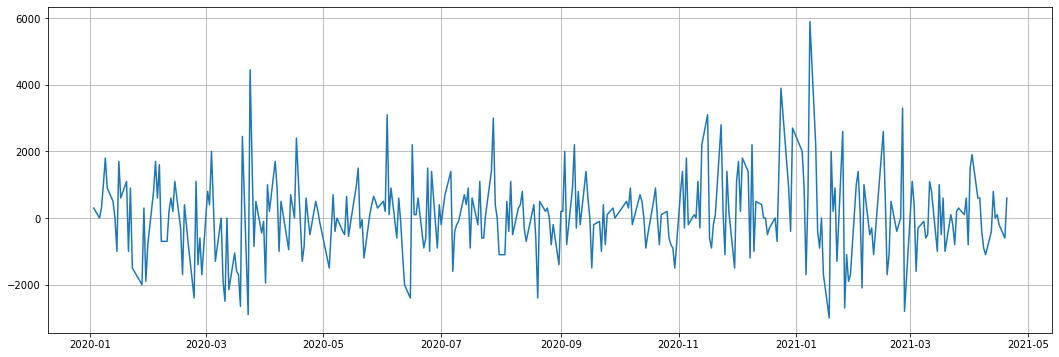

In [38]:
plt.figure(figsize=(18, 6))
plt.plot(df_1.index, df_1['price'])
plt.xlabel=("day")
plt.ylabel=("price")
plt.grid(True)
plt.show()

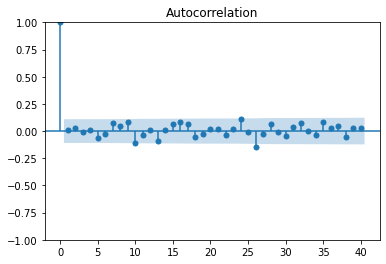

In [39]:
plot_acf(df_1, lags=40)
plt.show()

C:\Users\MJHwang\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


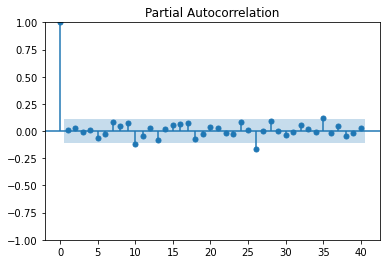

In [40]:
plot_pacf(df_1, lags=40)
plt.show()

- 차분 후 시계열도와 ACF, PACF 그래프를 그려본 결과 정상성을 만족함과 자기 상관 관계가 거의 존재하지 않음을 관찰할 수 있음

In [41]:
ADF_test(df_1)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.760280e+01
p-value                        3.913882e-30
Lags Used                      0.000000e+00
Number of Observations Used    3.200000e+02
Critical Value (1%)           -3.450952e+00
Critical Value (5%)           -2.870615e+00
Critical Value (10%)          -2.571605e+00
dtype: float64


In [42]:
kpss_test(df_1)

Results of KPSS Test:
Test Statistic           0.202379
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\MJHwang\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


- ADF test와 KPSS test 결과 둘 모두 유의수준 0.05 내에 귀무가설이 기각되므로 stationary함을 알 수 있음.
- 따라서 1차 차분된 데이터는 정상성을 만족함

## 2. 추정

In [43]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  322
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2736.895
Date:                Tue, 29 Aug 2023   AIC                           5477.791
Time:                        23:30:05   BIC                           5485.334
Sample:                             0   HQIC                          5480.803
                                - 322                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     89.4081     70.873      1.262      0.207     -49.501     228.317
sigma2       1.49e+06   8.82e+04     16.903      0.000    1.32e+06    1.66e+06
Ljung-Box (L1) (Q):                   0.05   Jarque-

## 3. 진단

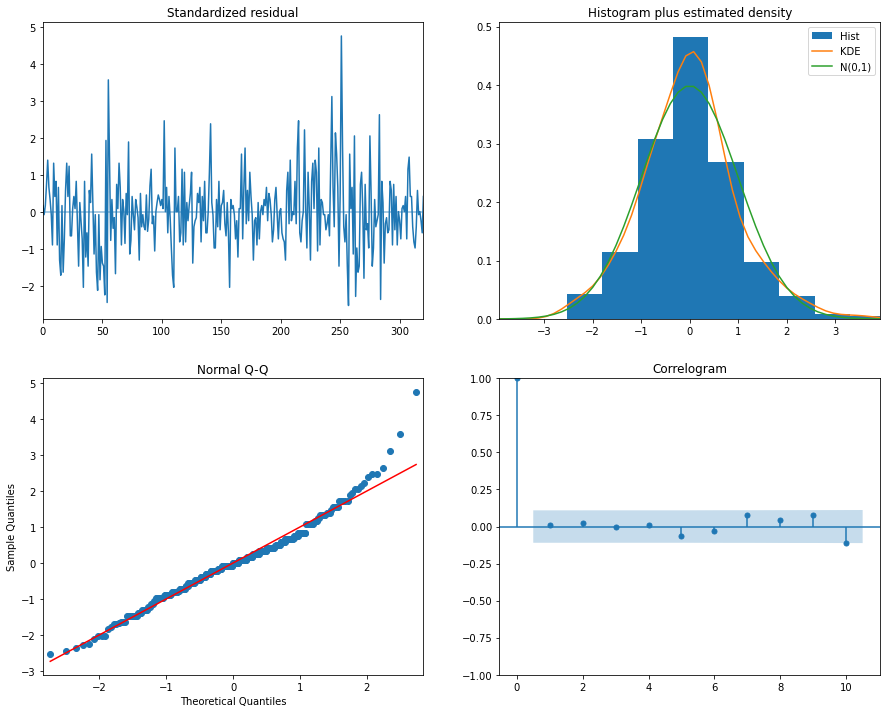

In [44]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

- 그래프를 살펴본 결과 KDE가 정규분포를 따르므로 잔차는 정규분포를 따른다는 것을 알 수 있고, Q-Q Plot에서 잔차의 분포가 표준정규분포에 가까우므로 선형성을 만족하고 있음을 알 수 있다. 

## 4. 예측

In [45]:
idx = int(len(samsung_df)*0.8) # 데이터 분할
df_train = samsung_df.iloc[:idx]
df_test = samsung_df.iloc[idx:]

print(df_train.shape, df_test.shape)

(257, 1) (65, 1)


In [46]:
arima = auto_arima(df_train, d=1, D=1, seasonal=True, m=4, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=4426.579, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=4468.194, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=4450.564, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=4445.036, Time=0.05 sec
 ARIMA(2,1,2)(0,1,1)[4]             : AIC=4445.989, Time=0.34 sec
 ARIMA(2,1,2)(1,1,0)[4]             : AIC=inf, Time=0.44 sec
 ARIMA(2,1,2)(2,1,1)[4]             : AIC=4433.279, Time=0.55 sec
 ARIMA(2,1,2)(1,1,2)[4]             : AIC=4433.799, Time=0.52 sec
 ARIMA(2,1,2)(0,1,0)[4]             : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,1,2)[4]             : AIC=4433.472, Time=0.50 sec
 ARIMA(2,1,2)(2,1,0)[4]             : AIC=inf, Time=0.46 sec
 ARIMA(2,1,2)(2,1,2)[4]             : AIC=4434.003, Time=0.52 sec
 ARIMA(1,1,2)(1,1,1)[4]             : AIC=4431.320, Time=0.11 sec
 ARIMA(2,1,1)(1,1,1)[4]             : AIC=inf, Time=0.33 sec
 ARIMA(3,1,2)(1,1,1)[4]             : AIC=4432.226, T

In [47]:
print(arima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  257
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 4)   Log Likelihood               -2206.289
Date:                             Tue, 29 Aug 2023   AIC                           4426.579
Time:                                     23:30:12   BIC                           4451.285
Sample:                                          0   HQIC                          4436.520
                                             - 257                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4557      0.064     22.803      0.000       1.331       1.581
ar.L2         -0.9461      

In [52]:
model_fit = arima.fit(df_train)
predict = model_fit.predict(n_periods=len(df_test))
df_pred = pd.DataFrame(predict.values, columns=['price'], index=df_test.index)
df_pred

C:\Users\MJHwang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,price
day,
2021-01-15,91481.893674
2021-01-18,91212.885195
2021-01-19,90851.185127
2021-01-20,91174.831732
2021-01-21,92341.638638
...,...
2021-04-14,116722.237664
2021-04-15,116375.933347
2021-04-16,116691.286937


In [53]:
df_f = pd.concat([df_train, df_pred], axis=0)
df_f

,price
day,
2020-01-02,55200.000000
2020-01-03,55500.000000
2020-01-06,55500.000000
2020-01-07,55800.000000
2020-01-08,56800.000000
...,...
2021-04-14,116722.237664
2021-04-15,116375.933347
2021-04-16,116691.286937


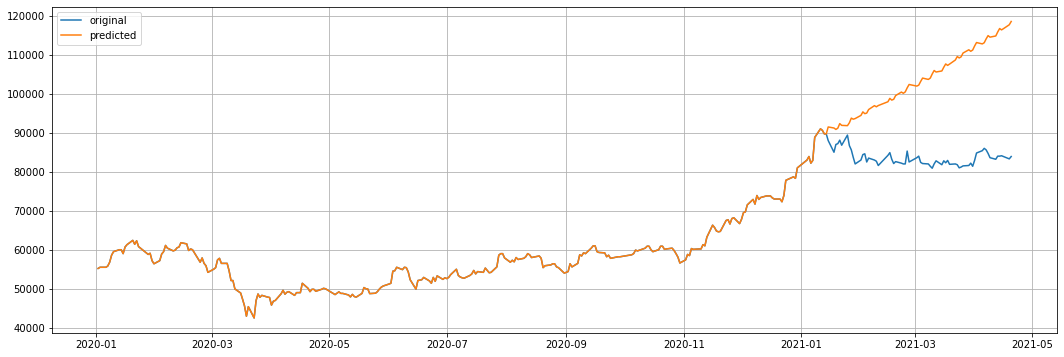

In [51]:
plt.figure(figsize=(18, 6))
plt.plot(samsung_df.index, samsung_df['price'], label='original')
plt.plot(df_final.index, df_final['price'], label='predicted')
plt.xlabel=("day")
plt.ylabel=("price")
plt.legend()
plt.grid(True)
plt.show()